In [1]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image, UnidentifiedImageError, ImageStat
import random
import hashlib

In [2]:
root_dir = "../data/raw/"
labels_df = pd.read_csv('../data/raw/dataset.csv')
print(labels_df)

          label  number_of_files
0  brain_glioma             2004
1   brain_menin             2004
2   brain_tumor             2048


/tmp/ipykernel_2405144/1401472554.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='number_of_files', data=labels_df, palette='Set2')


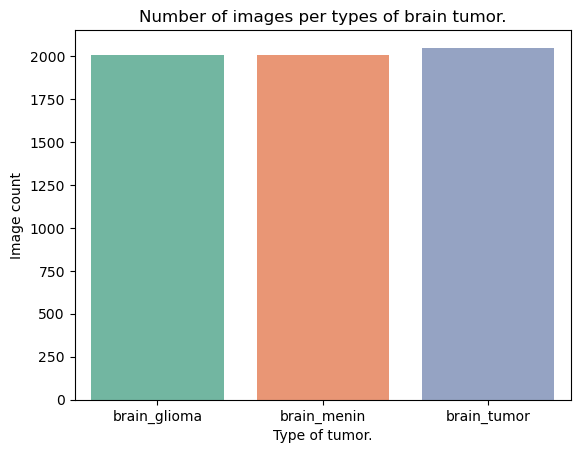

In [3]:
sns.barplot(x='label', y='number_of_files', data=labels_df, palette='Set2')
plt.title("Number of images per types of brain tumor.")
plt.xlabel("Type of tumor.")
plt.ylabel("Image count")
plt.show()

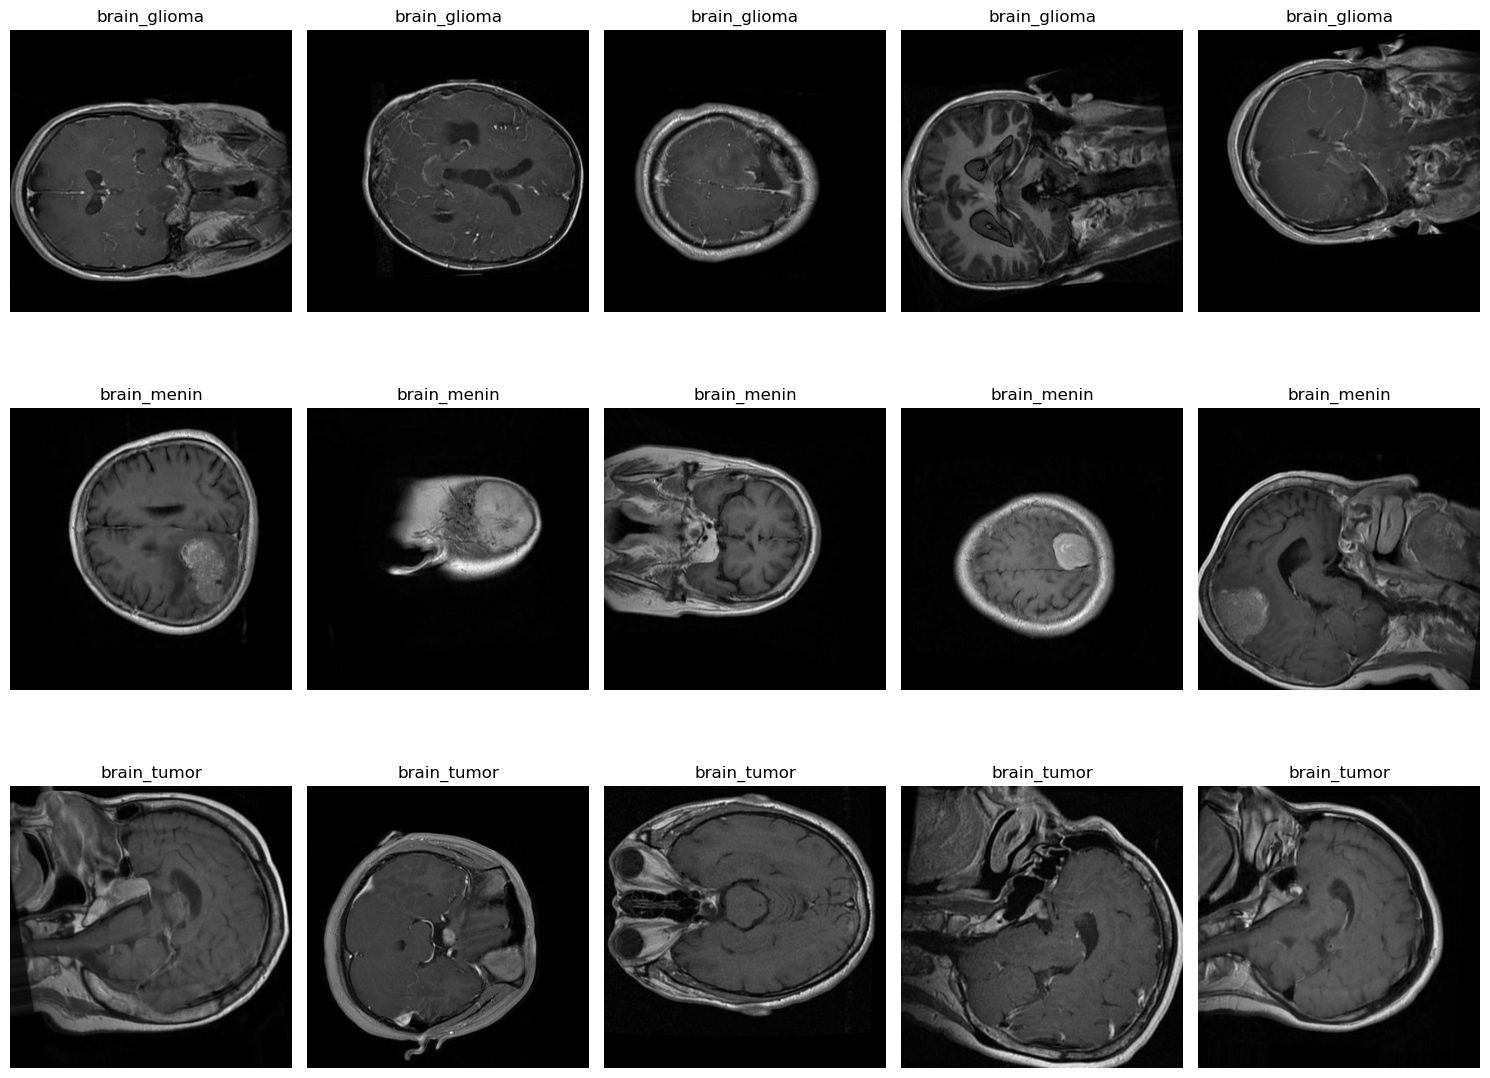

In [4]:
classes = labels_df['label'].tolist()
samples_per_class = 5

fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(15, 4 * len(classes)))

for i, cls in enumerate(classes):
    class_path = os.path.join(root_dir, cls)
    images = [img for img in os.listdir(class_path) if img.endswith(('.jpg'))]
    chosen = random.sample(images, samples_per_class)

    for j, img_name in enumerate(chosen):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert('RGB')
        axes[i, j].imshow(img)
        axes[i, j].set_title(cls)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

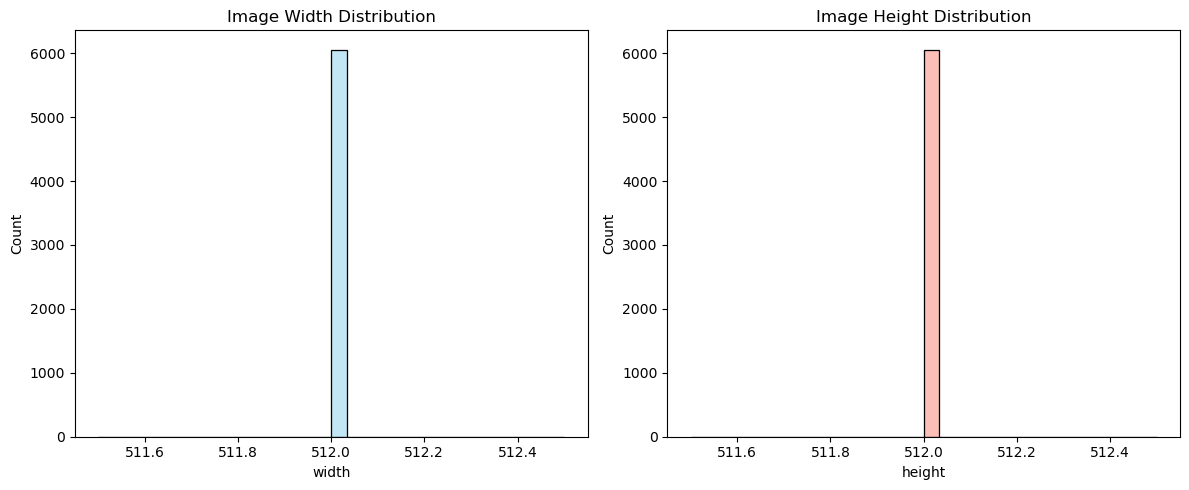

In [5]:
image_dims = []

for cls in classes:
    cls_dir = os.path.join(root_dir, cls)
    for img_file in os.listdir(cls_dir):
        if img_file.lower().endswith(('.jpg')):
            img_path = os.path.join(cls_dir, img_file)
            with Image.open(img_path) as img:
                image_dims.append(img.size)

sizes_df = pd.DataFrame(image_dims, columns=['width', 'height'])

# Plot distribution
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(sizes_df['width'], bins=30, kde=True, ax=axs[0], color='skyblue')
axs[0].set_title("Image Width Distribution")

sns.histplot(sizes_df['height'], bins=30, kde=True, ax=axs[1], color='salmon')
axs[1].set_title("Image Height Distribution")
plt.tight_layout()
plt.show()

In [6]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {
            cls: idx for idx, cls in enumerate(sorted(os.listdir(root_dir)))
            if os.path.isdir(os.path.join(root_dir, cls))
        }
        
        for cls in self.class_to_idx:
            cls_dir = os.path.join(root_dir, cls)
            for img_file in os.listdir(cls_dir):
                if img_file.endswith(('.jpg')):
                    self.image_paths.append(os.path.join(cls_dir, img_file))
                    self.labels.append(self.class_to_idx[cls])

        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]
    
    
dataset = BrainTumorDataset(root_dir=root_dir)


def get_mean_std(dataset, batch_size=256):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total = 0

    for images, _ in loader:
        batch = images.size(0)
        images = images.view(batch, 3, -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total += batch

    mean /= total
    std /= total
    return mean, std


mean, std = get_mean_std(dataset)
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.1543, 0.1543, 0.1543])
Std: tensor([0.1668, 0.1668, 0.1668])


In [7]:
corrupt_images = []

for path in dataset.image_paths:
    try:
        img = Image.open(path)
        img.verify()
    except (UnidentifiedImageError, OSError):
        corrupt_images.append(path)

print(f"Found {len(corrupt_images)} corrupt images.")

Found 0 corrupt images.


In [8]:
black_images = []

to_tensor = transforms.ToTensor()

for path in dataset.image_paths:
    img = to_tensor(Image.open(path).convert('RGB'))
    if torch.all(img == 0):
        black_images.append(path)

print(f"Found {len(black_images)} completely black images.")

Found 0 completely black images.


In [9]:
hashes = {}
duplicates = []

for path in dataset.image_paths:
    with open(path, 'rb') as f:
        filehash = hashlib.md5(f.read()).hexdigest()
    if filehash in hashes:
        duplicates.append((path, hashes[filehash]))
    else:
        hashes[filehash] = path

print(f"Found {len(duplicates)} duplicate image pairs.")

Found 44 duplicate image pairs.


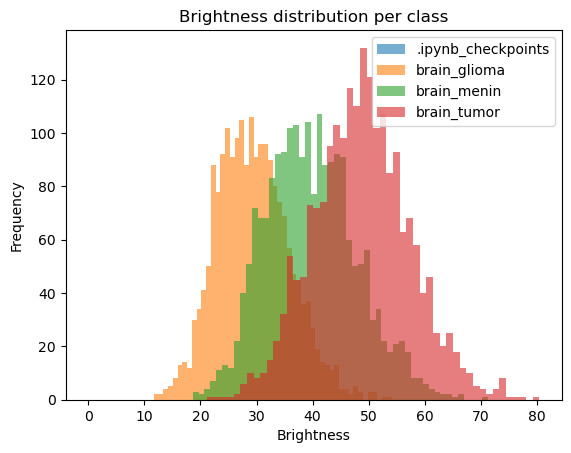

In [10]:
brightness = {cls: [] for cls in dataset.class_to_idx}

for path, label in zip(dataset.image_paths, dataset.labels):
    img = Image.open(path).convert('L')  # Grayscale
    stat = ImageStat.Stat(img)
    brightness_value = stat.mean[0]
    for cls_name, idx in dataset.class_to_idx.items():
        if idx == label:
            brightness[cls_name].append(brightness_value)

# Plot brightness distribution
for cls, values in brightness.items():
    plt.hist(values, bins=50, alpha=0.6, label=cls)

plt.legend()
plt.title("Brightness distribution per class")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.show()